In [1]:
import math
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from board import Board
from agent import Agent
# set white background
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
board = Board()

print(board)


. % . % 
. % P % 
. . . . 
. . E . 


In [3]:


def get_best_action(board, agent):
    pp = board.get_position(2)
    tp = board.get_position(3)
    
    best_action = None
    best_value = -math.inf
    
    for a in range(board.get_total_actions()):
        board_copy = board.copy()
        board_copy.do_action(pp, tp, a)
        
        with torch.no_grad():
            agent.eval()
            value = agent(board_copy.to_tensor()).item()
        
        if value > best_value:
            best_value = value
            best_action = a
            
    return best_action




def evaluate(policy, n=100, max_steps=20):
    
    v = 0
    for _ in range(n):
        board = Board()
        pp = board.get_position(2)
        tp = board.get_position(3)
        
        for _ in range(max_steps):
            a = get_best_action(board, policy)
            board.do_action(pp, tp, a)
            pp = board.get_position(2)
            tp = board.get_position(3)
            
            if board.is_win():
                v += 1
                break
        
    return v / n




  0%|          | 0/4000 [00:00<?, ?it/s]

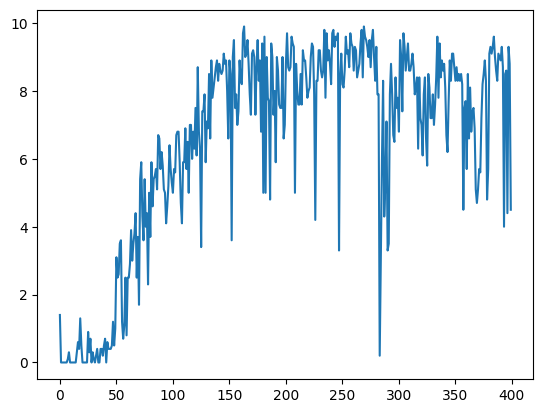

In [5]:

lh = []
agent = Agent(80)
# agent.load_state_dict(torch.load('bagent.pt'))
optimizer = optim.Adam(agent.parameters(), lr=0.001)
crit = nn.MSELoss()

mem_size = 3000
boards_memory = []
rewards_memory = []

best_value = -math.inf

for e in tqdm(range(4000)):
    
    if e % 10 == 0:
        value = evaluate(agent)
        if value > best_value:
            best_value = value
            torch.save(agent.state_dict(), 'bagent.pt')
        lh.append(value)
    
    board = Board()
    
    pp = board.get_position(2)
    tp = board.get_position(3)
    
    rewards = []
    
    for _ in range(20):
        if random.random() < 0.1:
            a = random.randint(0, board.get_total_actions()-1)
        else:
            a = get_best_action(board, agent)
        
        pp = board.get_position(2)
        tp = board.get_position(3)
        
        board.do_action(pp, tp, a)
        
        if board.is_win():
            rewards.append((board.copy(), 15))
            break
        
        elif board.board[1][0] == 4 and board.board[0][0] != 3 or board.board[1][2] == 4 and board.board[0][2] != 3:
            rewards.append((board.copy(), -10))        
        else:
            rewards.append((board.copy(), -1))
            
            
    acc_reward = 0
    agent.train()
    for b, r in reversed(rewards):
        acc_reward += r
        boards_memory.append(b.to_tensor().unsqueeze(0))
        rewards_memory.append(torch.Tensor([acc_reward]).unsqueeze(0))

    if len(boards_memory) > mem_size:
        boards_memory = boards_memory[len(boards_memory) - mem_size:]
        rewards_memory = rewards_memory[len(rewards_memory) - mem_size:]
        
    for b, r in DataLoader(TensorDataset(torch.cat(boards_memory), torch.cat(rewards_memory)), batch_size=32, shuffle=True):
        optimizer.zero_grad()
        pred = agent(b)
        loss = crit(pred, r)
        loss.backward()
        optimizer.step()

plt.plot(lh)
plt.show()

In [10]:
board = Board()
agent.load_state_dict(torch.load('bagent.pt'))
print(board)
print('         ')
for i in range(10):
    print(i)
    a = get_best_action(board, agent)
    pp = board.get_position(2)
    tp = board.get_position(3)
    board.do_action(pp, tp, a)
    print(board)
    print('-' * 10)
    
    if board.is_win():
        break
        

. % . % 
. % . % 
. . E . 
P . . . 

         
0
. % . % 
. % . % 
. . E . 
. P . . 

----------
1
. % . % 
. % E % 
. . . . 
. P . . 

----------
2
. % . % 
. % E % 
. P . . 
. . . . 

----------
3
. % E % 
. % . % 
. P . . 
. . . . 

----------
4
. % E % 
. % # % 
. P . . 
. . . . 

----------


In [17]:
torch.save(agent.state_dict(), 'agent.pt')

In [5]:
agent = Agent(80)
agent.load_state_dict(torch.load('bagent.pt'))
evaluate(agent)

0.0